In [147]:
#importar bibliotecas
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [148]:
#lendo o arquivo BRAS.csv
#O arquivo utilizado foi baixado do site www.football-data.co.uk, que agrega informações de diversos campeonatos
#ao redor do mundo.

data=pd.read_csv('./assets/bra.csv')

#Verificando as 5 primeiras linhas do arquivo a ser utilizado
display(data.head())

#Notes for football data

#Country = país do campeonato
#League = nome da liga
#game_id = id do jogo
#Season = temporada
#date = data do jogo
#Time = hora do jogo
#Home = Time da casa
#home_id = id do time da casa
#Away = time visitante
#Away_id =  id do time visitante
#HG = Gols do time da casa
#AG = Gols do time visitante
#Res = Resultado do jogo (D=Draw, H=Home win, A=Away win)
#PH = probablidade vitória time da casa provida pela Pinacle (casa de aposta inglesa)
#PD = probablidade empate provida pela Pinacle (casa de aposta inglesa)
#PA = probablidade vitória time visitante provida pela Pinacle (casa de aposta inglesa)
#MaxH = probablidade vitória time da casa provida pela OddsPortal (casa de aposta inglesa)
#MaxD = probablidade empate provida pela OddsPortal (casa de aposta inglesa)
#MaxA = probablidade vitória time visitante provida pela OddsPortal (casa de aposta ingles
#AvgH = probablidade média de vitória em casa provida pela OddsPortal (casa de aposta inglesa)
#AvgD = probablidade média de empate provida pela OddsPortal (casa de aposta inglesa)
#AvgA = probablidade média de vitória pelo time visitante provida pela OddsPortal (casa de aposta inglesa)


,Country,League,game_id,Season,Date,Time,Home,home_id,Away,Away_id,...,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,1,2012,19-05-12,22:30,Palmeiras,21,Portuguesa,21,...,0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Brazil,Serie A,2,2012,19-05-12,22:30,Sport Recife,27,Flamengo RJ,27,...,0,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Brazil,Serie A,3,2012,20-05-12,1:00,Figueirense,13,Nautico,13,...,1,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Brazil,Serie A,4,2012,20-05-12,20:00,Botafogo RJ,7,Sao Paulo,7,...,1,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Brazil,Serie A,5,2012,20-05-12,20:00,Corinthians,9,Fluminense,9,...,2,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


In [149]:
#Explorando os dados
#Base de dados de dos campeonatos de 2012 a 2017

matches = data.shape[0]

features = data.shape[1] -1 #Retirando a coluna Resultado

home_win = len(data[data.Res==1])
away_win = len(data[data.Res==2])
draw = len(data[data.Res==0])
val=[home_win,away_win,draw]

win_rate = (float(home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

#Podemos notar que o "fator casa" é importante , sendo que em quase 50% do jogos são ganhos pelo time da casa.

Total de jogos:  2279
Total de colunas:  21
Total de jogos ganhos em casa:  1133
Total de jogos ganhos pelo visitante:  553
Total de jogos empatados:  593
Percentual de jogos ganhos em casa: 49.71%


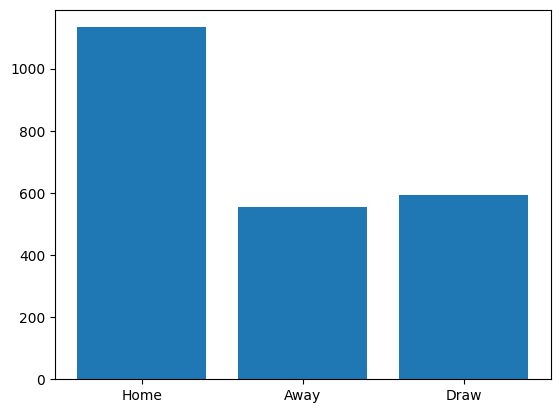

In [150]:
#Visualizando os dados

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Away', 'Draw'))
plt.show()


In [151]:
#Preparando os dados


#Deixar somente as variáveis numericas 
num_data = data.drop(['Country','League','Season','Date','Time','Home','Away'],1)

display(num_data.head())


C:\Users\Kevin\AppData\Local\Temp\ipykernel_10512\2694302212.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  num_data = data.drop(['Country','League','Season','Date','Time','Home','Away'],1)


,game_id,home_id,Away_id,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,1,21,21,1,1,0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,2,27,27,1,1,0,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,3,13,13,2,1,1,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,4,7,7,4,2,1,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,5,9,9,0,1,2,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


In [152]:
#separa as features 
features = num_data.drop(['Res'],1)


#separa as labels
labels = num_data['Res']

print('Features')
print (features.head())

print ('=========')

print ('Labels')
print (labels.head())

Features
   game_id  home_id  Away_id  HG  AG    PH    PD    PA  MaxH  MaxD  MaxA  \
0        1       21       21   1   1  1.75  3.86  5.25  1.76  3.87  5.31   
1        2       27       27   1   1  2.83  3.39  2.68  2.83  3.42  2.70   
2        3       13       13   2   1  1.60  4.04  6.72  1.67  4.05  7.22   
3        4        7        7   4   2  2.49  3.35  3.15  2.49  3.39  3.15   
4        5        9        9   0   1  1.96  3.53  4.41  1.96  3.53  4.41   

   AvgH  AvgD  AvgA  
0  1.69  3.50  4.90  
1  2.59  3.23  2.58  
2  1.59  3.67  5.64  
3  2.35  3.26  2.84  
4  1.89  3.33  3.89  
Labels
0    0
1    0
2    1
3    1
4    2
Name: Res, dtype: int64


C:\Users\Kevin\AppData\Local\Temp\ipykernel_10512\1752638190.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features = num_data.drop(['Res'],1)


In [153]:
#Escoolhendo as melhores features com Kbest

features_list = ('HG','AG','PH','PD','PA','MaxH','MaxD','MaxA','AvgH','AvgD','AvgA')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_

raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print (ordered_pairs)

[('PA', 740.4065621193932), ('MaxH', 731.7074700471329), ('MaxD', 81.51748572743963), ('AvgD', 80.67054047107476), ('AvgH', 63.290872018071454), ('MaxA', 40.62018755299711), ('AvgA', 40.54491193487282), ('AG', 0.6533077251586757), ('PD', 0.027363118243961364), ('PH', 0.027363118243961364)]


In [154]:
#separa as features com base nas melhores features para treinamento
features = num_data.drop(['Res','game_id','home_id','Away_id', 'AG','PD','PH'],1)


#separa as labels para treinamento
labels = num_data['Res']

print('Features')
print (features.head())

print ('=========')

print ('Labels')
print (labels.head())


C:\Users\Kevin\AppData\Local\Temp\ipykernel_10512\1735281590.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features = num_data.drop(['Res','game_id','home_id','Away_id', 'AG','PD','PH'],1)


Features
   HG    PA  MaxH  MaxD  MaxA  AvgH  AvgD  AvgA
0   1  5.25  1.76  3.87  5.31  1.69  3.50  4.90
1   1  2.68  2.83  3.42  2.70  2.59  3.23  2.58
2   2  6.72  1.67  4.05  7.22  1.59  3.67  5.64
3   4  3.15  2.49  3.39  3.15  2.35  3.26  2.84
4   0  4.41  1.96  3.53  4.41  1.89  3.33  3.89
Labels
0    0
1    0
2    1
3    1
4    2
Name: Res, dtype: int64


In [155]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print ('Features: ',features_scale.shape)
print (features_scale)

Features:  (2279, 8)
[[0.16666667 0.21853547 0.07060334 ... 0.08239095 0.15945946 0.26920093]
 [0.16666667 0.0715103  0.20795892 ... 0.22778675 0.08648649 0.08921645]
 [0.33333333 0.30263158 0.05905006 ... 0.06623586 0.20540541 0.32660978]
 ...
 [0.16666667 0.41647597 0.02695764 ... 0.03069467 0.50540541 0.48875097]
 [0.33333333 0.50171625 0.02439024 ... 0.02423263 0.51351351 0.60822343]
 [0.16666667 0.10526316 0.13863928 ... 0.15831987 0.13783784 0.14041893]]


In [156]:
#Separa em treinamento e teste
#Separação manual para manter a ordem cronológica, uma vez que temos informação temporal. 
#Treino linhas [:1932]
#Teste linhas [1932:2155]
#previsão linhas [2155:2280]


X_train = features_scale[:1932]
X_test = features_scale[1932:2155]
y_train = labels[:1932]
y_test = labels[1932:2155]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))


1932 1932
223 223


In [157]:
#Treinando e testando os modelos
print ('LogisticRegression')


clf_LR = LogisticRegression(multi_class='multinomial',max_iter=2000)
clf_LR.fit(X_train, y_train)
pred= clf_LR.predict(X_test)

lg_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred,average = 'micro')
print ('Acurácia LogisticRegression:{}'.format(lg_acc))
print ('F1 Score:{}'.format(f1) )

LogisticRegression
Acurácia LogisticRegression:0.57847533632287
F1 Score:0.57847533632287


In [158]:
#Testando LogistRegression hyper parameters

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid)

search.fit(X_train,y_train)
clf = search.best_estimator_
pred= clf.predict(X_test)
lg_acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'macro')

print ('Acurácia LogisticRegression:{}'.format(lg_acc))
print ('F1 Score:{}'.format(f1) )

print (clf)

Acurácia LogisticRegression:0.57847533632287
F1 Score:0.5282488231236308
LogisticRegression(C=1, max_iter=1000)


In [159]:
#Treinando e testando os modelos
print ('SVC')


clf = SVC()
clf.fit(X_train, y_train)
pred= clf.predict(X_test)

svc_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='micro')
print ('Acurácia SVC:{}'.format(svc_acc))
print ('F1 Score:{}'.format(f1) )

SVC
Acurácia SVC:0.57847533632287
F1 Score:0.57847533632287


In [160]:
#Testando SVC hyper parameters

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(SVC(), param_grid)

search.fit(X_train,y_train)
clf_SVC = search.best_estimator_
pred= clf_SVC.predict(X_test)
acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'micro')

print ('F1 Score:{}'.format(f1))

print ('Acurácia LogisticRegression:{}'.format(acc))

print(clf_SVC)

F1 Score:0.5919282511210763
Acurácia LogisticRegression:0.5919282511210763
SVC(C=100)


In [161]:
#Treinando e testando os modelos
print ('Decision Tree')


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred= clf.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='macro')
print ('Acurácia Tree:{}'.format(dt_acc))
print ('F1 Score:{}'.format(f1) )


n_estimators = [10, 50, 100, 200]
max_depth = [3, 10, 20, 40]

Decision Tree
Acurácia Tree:0.4618834080717489
F1 Score:0.43570968039053143


In [162]:
#Testando Decision tree hyper parameters
print ('Decision Tree')

param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
    
  
}

search = GridSearchCV(DecisionTreeClassifier(), param_grid)

search.fit(X_train,y_train)
clf = search.best_estimator_
pred= clf.predict(X_test)
dt_acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'micro')

print ('Acurácia Decision Tree:{}'.format(dt_acc))
print ('F1 Score:{}'.format(f1) )

print (clf)

Decision Tree
Acurácia Decision Tree:0.48878923766816146
F1 Score:0.48878923766816146
DecisionTreeClassifier(max_depth=110, max_features=3, min_samples_leaf=5,
                       min_samples_split=12)


In [163]:
#Treinando e testando os modelos
print ('Naive baeys')


clf = GaussianNB()
clf.fit(X_train, y_train)
pred= clf.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='micro')
print ('Acurácia Naive baeys:{}'.format(nb_acc))
print ('F1 Score:{}'.format(f1) )

Naive baeys
Acurácia Naive baeys:0.5201793721973094
F1 Score:0.5201793721973094


In [164]:
#Executando a previsao

previsao=features_scale[2155:]

game_id_full=data['game_id']
game_id=game_id_full[2155:]

res_full=data['Res']
res=res_full[2155:]


pred=clf_SVC.predict(previsao)

df=pd.DataFrame({'real': res, 'previsao':pred, 'game_id':game_id})

print(df)

      real  previsao  game_id
2155     1         1     2156
2156     1         1     2157
2157     2         2     2158
2158     1         1     2159
2159     1         1     2160
...    ...       ...      ...
2274     0         0     2275
2275     0         0     2276
2276     1         1     2277
2277     1         1     2278
2278     2         1     2279

[124 rows x 3 columns]


<Axes: xlabel='previsao', ylabel='real'>

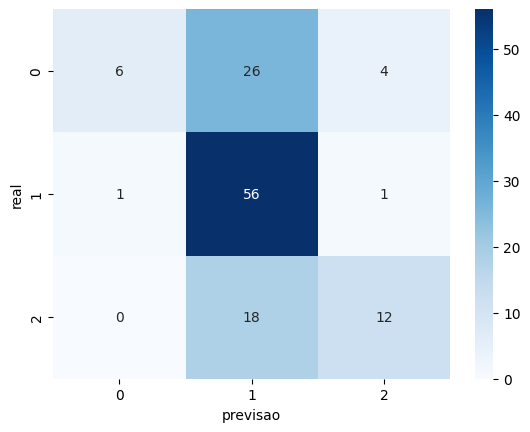

In [165]:
#confusion Matrix

df=pd.DataFrame(df,columns=['real','previsao' ])

cf_matrix=pd.crosstab(df['real'], df['previsao'], rownames=['real'] , colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='Blues')